In [15]:
from functools import partial
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [2]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060'

In [3]:
df = pd.read_csv('./Form-714-csv-files-June-2021/Part 3 Schedule 2 - Planning Area Hourly Demand.csv')
respondent_id = pd.read_csv('./Form-714-csv-files-June-2021/Respondent IDs.csv')
good_ids = respondent_id['respondent_id'].unique()[3:]
df = df[df['respondent_id'].isin(good_ids)]
hour_cols = [f'hour{i:02d}' for i in range(1, 25)]
df = df.loc[~(df[hour_cols] == 0).any(axis=1)]


In [4]:
def previous_day_index(respondent_data, x):
    respondent_data['plan_date'] == x - pd.Timedelta('1d')
    a_index = respondent_data.index[respondent_data['plan_date'] == x - pd.Timedelta('1d')]
    if len(a_index) == 0:
        return np.nan
    else:
        return a_index[0]

In [5]:
# Data Preparation
def prepare_data(df):
    # Keep hourly columns as features
    hour_cols = [f'hour{i:02d}' for i in range(1, 25)]
    
    # Convert date and extract features
    df['plan_date'] = pd.to_datetime(df['plan_date'])
    df['year'] = df['plan_date'].dt.year
    df['month'] = df['plan_date'].dt.month
    df['day_of_week'] = df['plan_date'].dt.dayofweek
    
    # Cyclic encoding for temporal features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Normalize year
    df['year'] = (df['year'] - df['year'].mean()) / df['year'].std()
    
    # Encode respondents
    df['respondent_id'] = df['respondent_id'].astype('category')
    df['respondent_idx'] = df['respondent_id'].cat.codes
    
    # Normalize load values per respondent
    for col in hour_cols:
        # save original data
        df['og_' + col] = df[col].copy()
        # Normalize load values per respondent
        df[col] = df.groupby('respondent_id')[col].transform(
            lambda x: (x - x.mean()) / x.std()
        )
    df = df.reset_index()
    df['prev_day_index'] = np.nan
    for a_id in df['respondent_id'].unique():
        respondent_data = df.loc[df['respondent_id'] == a_id]
        respondent_data.loc[:, 'prev_day_index'] = (
            respondent_data['plan_date'].apply(
                partial(previous_day_index, respondent_data)))
        df.loc[respondent_data.index, 'prev_day_index'] = respondent_data['prev_day_index']
    prev_hour_cols = ['prev_'+ a_hour for a_hour in hour_cols]
    df[prev_hour_cols] = np.nan
    with_prev = df['prev_day_index'].notna()
    df.loc[with_prev, prev_hour_cols] = (
        df.loc[df['prev_day_index'].loc[with_prev], hour_cols].values
    )
    df = df.dropna()
    return df


In [6]:
df_prep = prepare_data(df)

/tmp/ipykernel_3794540/3322726924.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('respondent_id')[col].transform(
/tmp/ipykernel_3794540/3322726924.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('respondent_id')[col].transform(
/tmp/ipykernel_3794540/3322726924.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[col] = df.groupby('respondent_id')[col].transform(
/

In [7]:
# PyTorch Dataset
class LoadDataset(Dataset):
    def __init__(self, df):
        self.respondent_idx = torch.LongTensor(df['respondent_idx'].values)
        self.prev_targets = torch.FloatTensor(
            df[[f'prev_hour{i:02d}' for i in range(1, 25)]].values)
        self.temporal = torch.FloatTensor(df[['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']].values)
        self.targets = torch.FloatTensor(
            df[[f'hour{i:02d}' for i in range(1, 25)]].values)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return (
            self.respondent_idx[idx],
            self.prev_targets[idx],
            self.temporal[idx],
            self.targets[idx]
        )


In [ ]:
# Neural Network Model
class LoadForecaster(nn.Module):
    def __init__(self, num_respondents, embedding_dim=64, hidden_dims=[512, 256, 128, 64]):
        super().__init__()
        # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embedding = nn.Embedding(num_respondents, embedding_dim)
        # self.embedding.to(device)
        self.feature_dim = 5  + 24 # 5 temporal features 24 previous obs
        
        self.net = nn.Sequential(
            nn.Linear(embedding_dim + self.feature_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(hidden_dims[2], hidden_dims[3]),
            nn.ReLU(),
            nn.Linear(hidden_dims[3], 24)
        )
        
    def forward(self, respondent_idx, temporal, prev_targets):
        embedded = self.embedding(respondent_idx)
        combined = torch.cat([embedded, temporal, prev_targets], dim=1)
        return self.net(combined).squeeze()


In [ ]:
# Training Setup
def train_model(df, num_epochs=100, batch_size=2**15):
    # Prepare data
    # df = prepare_data(df)
    
    # Split data
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:]
    
    # Create datasets/dataloaders
    train_dataset = LoadDataset(train_df)
    val_dataset = LoadDataset(val_df)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    num_respondents = len(df['respondent_id'].cat.categories)
    model = LoadForecaster(num_respondents)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for ridx, prev_targets, temporal, targets in train_loader:
            ridx = ridx.to(device)
            prev_targets = prev_targets.to(device)
            temporal = temporal.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(ridx, temporal, prev_targets)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * ridx.size(0)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for ridx, prev_targets, temporal, targets in val_loader:
                ridx = ridx.to(device)
                prev_targets = prev_targets.to(device)
                temporal = temporal.to(device)
                targets = targets.to(device)
                outputs = model(ridx, temporal, prev_targets)
                val_loss += criterion(outputs, targets).item() * ridx.size(0)
        
        # Print statistics
        train_loss = train_loss / len(train_dataset)
        val_loss = val_loss / len(val_dataset)
        print(f'Epoch {epoch+1:2} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    return model

In [10]:
model = train_model(df_prep)

Epoch  1 | Train Loss: 0.5447 | Val Loss: 0.3019
Epoch  2 | Train Loss: 0.2265 | Val Loss: 0.2053
Epoch  3 | Train Loss: 0.1740 | Val Loss: 0.1827
Epoch  4 | Train Loss: 0.1565 | Val Loss: 0.1717
Epoch  5 | Train Loss: 0.1461 | Val Loss: 0.1575
Epoch  6 | Train Loss: 0.1369 | Val Loss: 0.1511
Epoch  7 | Train Loss: 0.1291 | Val Loss: 0.1461
Epoch  8 | Train Loss: 0.1220 | Val Loss: 0.1399
Epoch  9 | Train Loss: 0.1155 | Val Loss: 0.1352
Epoch 10 | Train Loss: 0.1260 | Val Loss: 0.1459
Epoch 11 | Train Loss: 0.1149 | Val Loss: 0.1337
Epoch 12 | Train Loss: 0.1081 | Val Loss: 0.1294
Epoch 13 | Train Loss: 0.1053 | Val Loss: 0.1272
Epoch 14 | Train Loss: 0.1034 | Val Loss: 0.1260
Epoch 15 | Train Loss: 0.1019 | Val Loss: 0.1240
Epoch 16 | Train Loss: 0.1006 | Val Loss: 0.1242
Epoch 17 | Train Loss: 0.0994 | Val Loss: 0.1215
Epoch 18 | Train Loss: 0.0983 | Val Loss: 0.1229
Epoch 19 | Train Loss: 0.0990 | Val Loss: 0.1200
Epoch 20 | Train Loss: 0.0964 | Val Loss: 0.1193
Epoch 21 | Train Los

In [13]:
torch.save(model.state_dict(), 'load_forecaster_model.pth')

In [14]:
# model = LoadForecaster(num_respondents=len(df_prep['respondent_id'].cat.categories))
# model.load_state_dict(torch.load('load_forecaster_model.pth'))

In [16]:

# Generation and Visualization
def generate_and_compare(model, df, respondent_id, date, n_samples=10):
    # Prepare input
    respondent_data = df[df['respondent_id'] == respondent_id]
    sample = respondent_data[respondent_data['plan_date'] == date].iloc[0]
    
    with torch.no_grad():
        # Get original data
        original = torch.FloatTensor(sample[[f'hour{i:02d}' for i in range(1, 25)]]).unsqueeze(0)
        ridx = torch.LongTensor([sample['respondent_idx']])
        temporal = torch.FloatTensor(sample[['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]).unsqueeze(0)
        prev_targets = torch.FloatTensor(sample[[f'prev_hour{i:02d}' for i in range(1, 25)]]).unsqueeze(0)

        model.to('cpu')
        
        # Reconsortruct
        forecast_load = model(ridx, temporal, prev_targets)
        
    
    # Denormalize
    mean = respondent_data[[f'og_hour{i:02d}' for i in range(1, 25)]].mean().values 
    std = respondent_data[[f'og_hour{i:02d}' for i in range(1, 25)]].std().values
    
    original = original.squeeze().numpy() * std + mean
    previous_24 = prev_targets.squeeze().numpy() * std + mean
    forecast_load = forecast_load.squeeze().numpy() * std + mean
    
    # Plot
    hours = np.arange(24)
    plt.figure(figsize=(12, 6))
    plt.plot(hours, original, label='True load')
    plt.plot(hours, previous_24, label='Yesterday\'s load')
    plt.plot(hours, forecast_load, label='Forecast')
    plt.title(f'Load for Respondent {respondent_id} on {date}')
    plt.xlabel('Hour')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)
    plt.show()


2011-12-18
266


/tmp/ipykernel_3794540/809170326.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  original = torch.FloatTensor(sample[[f'hour{i:02d}' for i in range(1, 25)]]).unsqueeze(0)
/tmp/ipykernel_3794540/809170326.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temporal = torch.FloatTensor(sample[['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos']]).unsqueeze(0)
/tmp/ipykernel_3794540/809170326.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

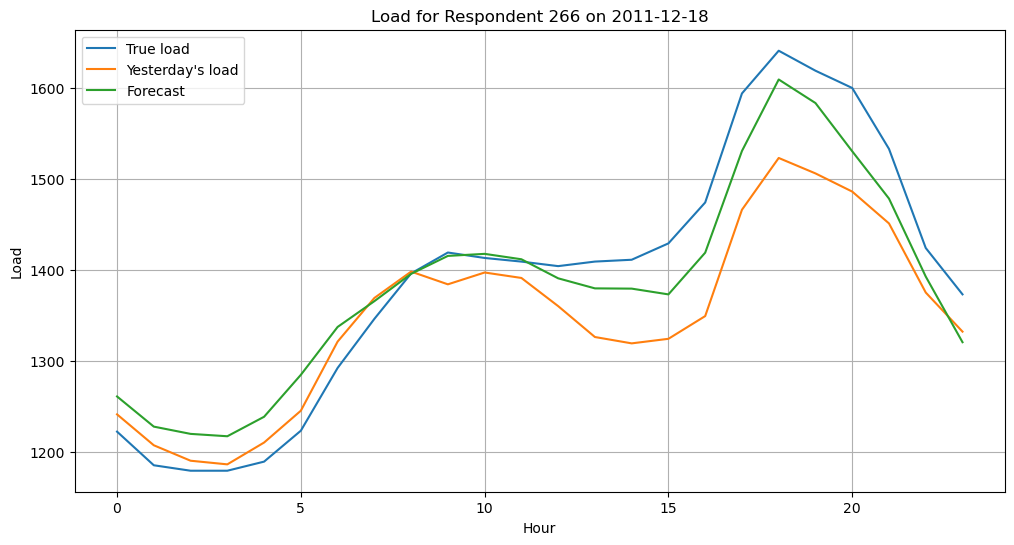

In [18]:
# respondent_id = np.random.choice(df['respondent_id'])
respondent_id = 266
respondent_data = df.loc[df['respondent_id']==respondent_id]
date = str(np.random.choice(respondent_data['plan_date']))[:10]
print(date)
print(respondent_id)

generate_and_compare(model, df_prep, 
                    respondent_id=respondent_id,  # Example respondent ID
                    date=date)   # Example date